<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>

Figure 1.1.a. Jupyter environment + Python notebooks

# Digital Earth Pacific Notebook 1 prepare postcard and load data to csv

The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe.

In [1]:
# # This cell is for papermill parameters. DO NOT CHANGE THE VARIABLE NAMES.
# # Default values for manual execution (papermill will override these)
# input_geojson_path = None
# output_csv_path = None

## Step 1.1: Configure the environment

In [2]:
import os
from datetime import datetime
from shapely.geometry import Polygon
from shapely import box
from pyproj import CRS 
import folium
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio as rio
import xarray as xr
import rioxarray
from ipyleaflet import basemaps
from numpy.lib.stride_tricks import sliding_window_view
import pystac_client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import planetary_computer
from odc.stac import load
from pystac.client import Client
from skimage.feature import graycomatrix, graycoprops
# from utils import load_data, scale, calculate_band_indices, apply_mask, mask_land, mask_deeps, mask_surf, mask_elevation, all_masks, glcm_features, do_prediction
import matplotlib.pyplot as plt
from odc.algo import binary_dilation
from skimage.morphology import disk
from utils import load_data, scale, calculate_band_indices, apply_mask, mask_land, mask_deeps, mask_elevation, all_masks, glcm_features, do_prediction

In [3]:
# Reload scripts and imports
%load_ext autoreload
%autoreload 2

In [4]:
# Predefined variable for title and version

# Enter your initials
initials = "nm"

# Enter your site name
site = "serua_revise"

# Date
date = datetime.now()

# Make a clean version string
version = f"{initials}-{site}-{date.strftime('%d%m%Y')}"
print(version)

nm-serua_revise-17082025


In [5]:
gdfs = []
postcards_path = "training-data/"
file_extension: str = ".geojson"

for filename in os.listdir(postcards_path):
    file_path = os.path.join(postcards_path, filename)
    if os.path.isfile(file_path) and filename.endswith(file_extension):
    # try:
        gdf = gpd.read_file(file_path)
        gdfs.append(gdf)

In [6]:
for filename in os.listdir(postcards_path):
    file_path = os.path.join(postcards_path, filename)
    if os.path.isfile(file_path) and filename.endswith(file_extension):
        print(filename) # This line will print the name of each GeoJSON file
        # The rest of your code to read the file and append to gdfs
        # gdf = gpd.read_file(file_path)
        # gdfs.append(gdf)

print("\nFinished listing GeoJSON files.")

serua_revise_postcard.geojson
serua_postcard.geojson

Finished listing GeoJSON files.


## Step 1.2: Configure STAC access and search parameters

In [7]:
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

In [8]:
# filename = "nm-efate-27072025_postcard.geojson"

In [9]:
# training = gpd.read_file(f"training-data/{site}_postcard.geojson")
# training = training.to_crs("EPSG:4326")
# min_lon, min_lat, max_lon, max_lat = training.total_bounds

# bbox = [min_lon, min_lat, max_lon, max_lat]

In [10]:
# Serua-Deuba
bbox = [177.85649, -18.30487, 178.01041, -18.25023]

In [11]:
datetime = "2024"

items = client.search(
    collections=["dep_s2_geomad"],
    datetime=datetime,
    bbox=bbox
).item_collection()

print(f"Found {len(items)} items in for {datetime}")

Found 1 items in for 2024


In [12]:
measurements = ["nir", "red", "blue", "green", "emad", "smad", "bcmad", "green", "nir08", "nir09", "swir16", "swir22", "coastal", "rededge1", "rededge2", "rededge3"]
data = load_data(
    items,
    measurements,
    bbox,
)
    
# Now you can use the 'data' variable
print(data)

<xarray.Dataset> Size: 39MB
Dimensions:      (y: 638, x: 1714, time: 1)
Coordinates:
  * y            (y) float64 5kB -2.053e+06 -2.053e+06 ... -2.06e+06 -2.06e+06
  * x            (x) float64 14kB 3.101e+06 3.101e+06 ... 3.118e+06 3.118e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/15)
    nir          (time, y, x) uint16 2MB dask.array<chunksize=(1, 638, 1714), meta=np.ndarray>
    red          (time, y, x) uint16 2MB dask.array<chunksize=(1, 638, 1714), meta=np.ndarray>
    blue         (time, y, x) uint16 2MB dask.array<chunksize=(1, 638, 1714), meta=np.ndarray>
    green        (time, y, x) uint16 2MB dask.array<chunksize=(1, 638, 1714), meta=np.ndarray>
    emad         (time, y, x) float32 4MB dask.array<chunksize=(1, 638, 1714), meta=np.ndarray>
    smad         (time, y, x) float32 4MB dask.array<chunksize=(1, 638, 1714), meta=np.ndarray>
    ...           ...
    swir16       (time, y, x) uint16 2MB dask.array<chun

In [13]:
dask_client = DaskClient(n_workers=1, threads_per_worker=16, memory_limit='16GB')
configure_s3_access(cloud_defaults=True, requester_pays=True)

In [14]:
scaled = scale(data)
scaled = scaled.compute().squeeze()

In [15]:
# Explore the site we are working on
scaled.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

In [16]:
scaled

<xarray.Dataset> Size: 118MB
Dimensions:      (y: 638, x: 1714)
Coordinates:
  * y            (y) float64 5kB -2.053e+06 -2.053e+06 ... -2.06e+06 -2.06e+06
  * x            (x) float64 14kB 3.101e+06 3.101e+06 ... 3.118e+06 3.118e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/15)
    nir          (y, x) float64 9MB 0.3626 0.3517 0.3539 ... 0.0334 0.0334
    red          (y, x) float64 9MB 0.0216 0.0198 0.0192 ... 0.0369 0.0372
    blue         (y, x) float64 9MB 0.0222 0.0207 0.0207 ... 0.0571 0.0561
    green        (y, x) float64 9MB 0.042 0.04 0.0423 ... 0.0467 0.045 0.0452
    emad         (y, x) float32 4MB 0.06211 0.06364 0.06855 ... 0.1014 0.09429
    smad         (y, x) float32 4MB 5.783e-08 8.552e-08 ... 3.906e-06 3.906e-06
    ...           ...
    swir16       (y, x) float64 9MB 0.1644 0.1646 0.1677 ... 0.034 0.0329 0.0329
    swir22       (y, x) float64 9MB 0.069 0.0692 0.0704 ... 0.0328 0.0316 0.0317
    coastal      (y, x) float64 9MB 0.0177 0.0178 0.0183 ... 0.0642 0.0631
    rededge1     (y, x) float64 9MB 0.078 0.0781 0.0803 ... 0.0402 0.0391 0.0388
    rededge2     (y, x) float64 9MB 0.2999 0.2998 0.3076 ... 0.038 0.0368 0.0367
    rededge3     (y, x) float64 9MB 0.3771 0.3771 0.3853 ... 0.039 0.0378 0.0379

In [17]:
scaled = calculate_band_indices(scaled)
Dataset = scaled

### GLCM texture analysis

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [18]:
# WINDOW_SIZE = 9
# LEVELS = 32

# # Input
# max = scaled.blue.max().values
# min = scaled.blue.min().values
# # Scale to 0-LEVELS for GLCM
# img = ((scaled.blue - min) / (max - min) * (LEVELS - 1)).clip(0, LEVELS - 1).values.astype(np.uint8)

# # Extract overlapping windows
# patches = sliding_window_view(img, (WINDOW_SIZE, WINDOW_SIZE))
# # Shape: (rows, cols, win_y, win_x)


In [19]:
# import numpy as np # Ensure numpy is imported if not already

# # Assuming 'patches' is a 4D NumPy array with dimensions (y_coords, x_coords, window_y_size, window_x_size)
# # To get the first patch (at y=0, x=0), you would index it like this:
# sample_patch_data = patches[0, 0, :, :]

# # Verify the shape of the extracted sample patch data
# print(f"Shape of sample_patch_data: {sample_patch_data.shape}")

# # Call glcm_features directly on this 2D sample data
# sample_result = glcm_features(sample_patch_data)

# # Print the shape of the result to get the number of features
# print(f"Shape of glcm_features output for a single patch: {sample_result.shape}")

Shape of sample_patch_data: (9, 9)
Shape of glcm_features output for a single patch: (7,)


In [20]:
# # Use apply_ufunc to vectorize over (row, col) dimensions
# result = xr.apply_ufunc(
#     glcm_features,
#     xr.DataArray(patches, dims=["y", "x", "win_y", "win_x"]),
#     input_core_dims=[["win_y", "win_x"]],
#     output_core_dims=[["feature"]],
#     vectorize=True,
#     dask="parallelized",
#     output_dtypes=[np.float32]
# )

# # Add coordinates & names
# pad = WINDOW_SIZE - 1
# result = result.assign_coords({
#     "y": scaled.y[: -pad],
#     "x": scaled.x[: -pad],
#     "feature": ["contrast", "homogeneity", "energy", "ASM", "correlation", "mean", "entropy"]
# })

# result_bands = result.to_dataset(dim="feature")

# # Combine with original
# combined = scaled.copy()
# combined = combined.assign(result_bands)

# combined

In [24]:
combined = scaled
combined.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

In [25]:
masked_combined, mask = all_masks(combined, return_mask = True)
mask.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

In [26]:
masked_combined.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site, tiles=basemaps.Esri.WorldImagery)

/srv/conda/envs/notebook/lib/python3.10/site-packages/odc/geo/_rgba.py:55: RuntimeWarning: invalid value encountered in cast
  return x.astype("uint8")


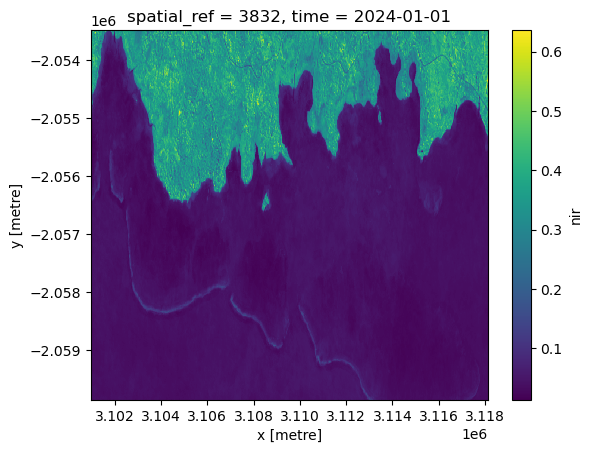

In [27]:
combined.nir.plot()

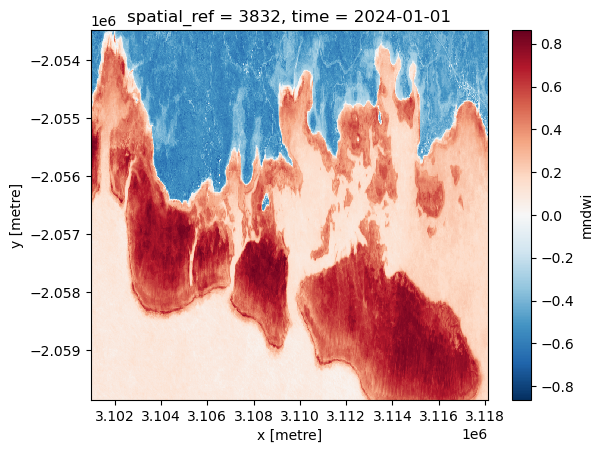

In [28]:
combined.mndwi.plot()

In [29]:
combined

<xarray.Dataset> Size: 223MB
Dimensions:      (y: 638, x: 1714)
Coordinates:
  * y            (y) float64 5kB -2.053e+06 -2.053e+06 ... -2.06e+06 -2.06e+06
  * x            (x) float64 14kB 3.101e+06 3.101e+06 ... 3.118e+06 3.118e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/27)
    nir          (y, x) float64 9MB 0.3626 0.3517 0.3539 ... 0.0334 0.0334
    red          (y, x) float64 9MB 0.0216 0.0198 0.0192 ... 0.0369 0.0372
    blue         (y, x) float64 9MB 0.0222 0.0207 0.0207 ... 0.0571 0.0561
    green        (y, x) float64 9MB 0.042 0.04 0.0423 ... 0.0467 0.045 0.0452
    emad         (y, x) float32 4MB 0.06211 0.06364 0.06855 ... 0.1014 0.09429
    smad         (y, x) float32 4MB 5.783e-08 8.552e-08 ... 3.906e-06 3.906e-06
    ...           ...
    ndwi         (y, x) float64 9MB -0.7924 -0.7958 -0.7865 ... 0.148 0.1501
    b_g          (y, x) float64 9MB 0.5286 0.5175 0.4894 ... 1.27 1.269 1.241
    b_r          (y, x) float64 9MB 1.028 1.045 1.078 ... 1.565 1.547 1.508
    mci          (y, x) float64 9MB 4.649 4.503 4.407 ... 0.8657 0.8542 0.8608
    ndci         (y, x) float64 9MB 0.5663 0.5955 0.6141 ... 0.02895 0.02105
    ln_bg        (y, x) float64 9MB -0.6376 -0.6587 -0.7147 ... 0.2381 0.216

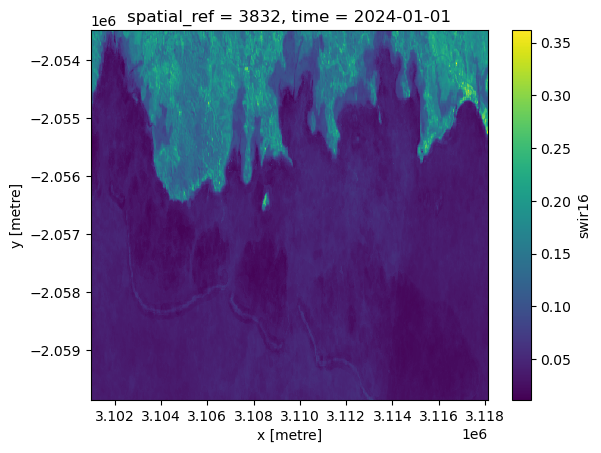

In [30]:
swir_mask = (combined.swir16).plot()

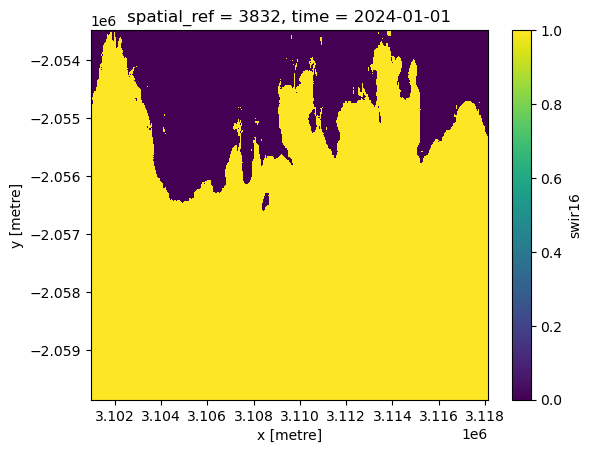

In [31]:
swir_mask = (combined.swir16 < 0.08).plot()

In [32]:
swir_mask = (combined.swir16 < 0.06)

In [33]:
swir_mask = swir_mask.astype('uint8')
swir_mask.odc.write_cog("swir_mask.tif", overwrite=True)

PosixPath('swir_mask.tif')

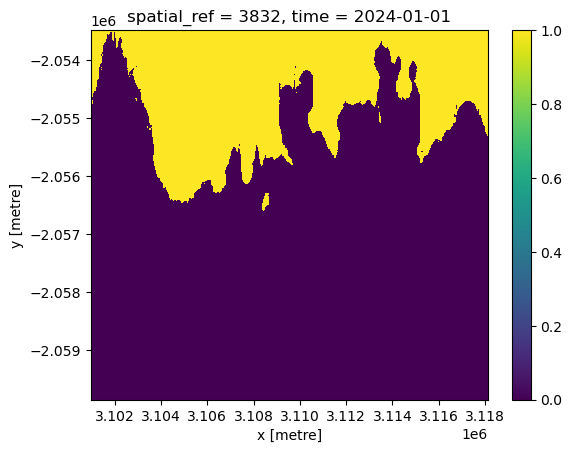

In [34]:
swir_mask = (combined.swir16 > 0.08)

land_threshold = -0.2
land_mask = (combined.mndwi<land_threshold).squeeze()

swir_mask = swir_mask.astype(bool)
land_mask = land_mask.astype(bool)

land_mask = land_mask + swir_mask
land_mask.plot()

In [35]:
# surf_mask = surf_mask & water_mask
# surf_mask.plot()

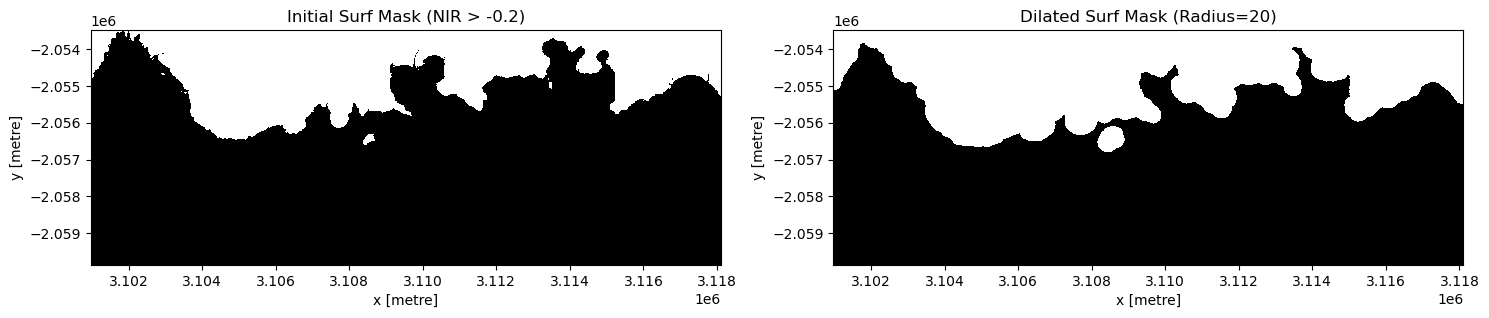

In [36]:
land_mask = land_mask.chunk({'x': 512, 'y': 512})

land_mask = land_mask.astype(bool)
land_dilation_radius = 20


dilated_land_mask = binary_dilation(land_mask, radius=land_dilation_radius)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot Initial Mask
land_mask.plot.imshow(
    ax=axes[0],
    cmap='gray', # 'gray' or 'Greys_r' are good for binary masks
    add_colorbar=False
)
axes[0].set_title(f'Initial Surf Mask (NIR > {land_threshold})')
axes[0].set_aspect('equal', adjustable='box')


# Plot Dilated Mask
dilated_land_mask.plot.imshow(
    ax=axes[1],
    cmap='gray', # Use the same colormap for comparison
    add_colorbar=False,
)
axes[1].set_title(f'Dilated Surf Mask (Radius={land_dilation_radius})')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [37]:
# # Assuming dilated_land_mask is your xarray.DataArray (boolean type)
# dilated_land_mask = dilated_land_mask.astype('uint8')

# dilated_land_mask.odc.write_cog("dilated_mask.tif", overwrite=True)

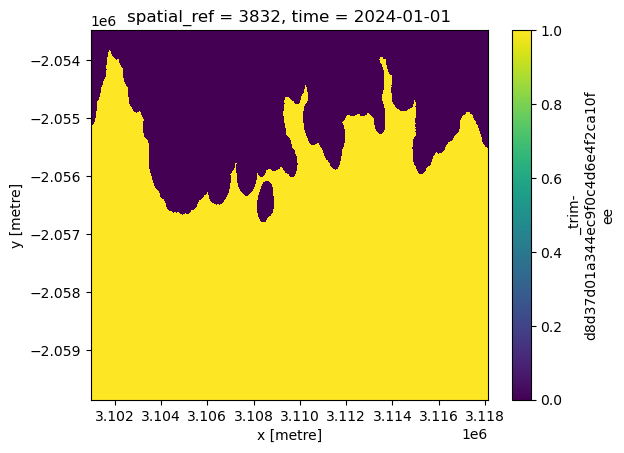

In [38]:

dilated_land_mask = dilated_land_mask.astype(bool)

water_mask = ~dilated_land_mask

water_mask.plot()


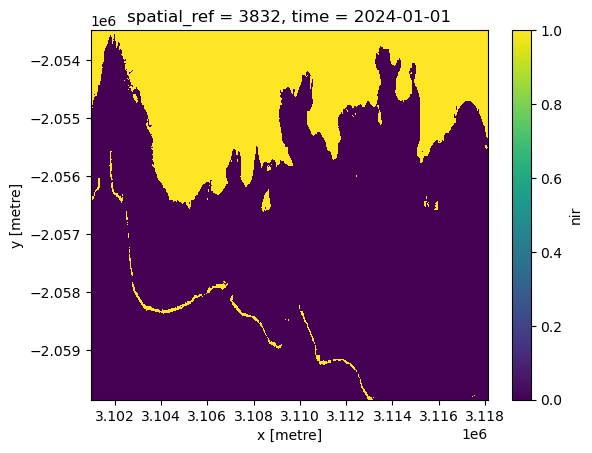

In [39]:

# from scipy.ndimage import binary_dilation
surf_threshold = 0.08

surf_mask = combined.nir > surf_threshold
# surf_mask = combined.nir.where(combined.nir<surf_threshold).squeeze()
# surf_mask = ~surf_mask
# surf_mask = combined.nir.where(surf_threshold)
surf_mask.plot()

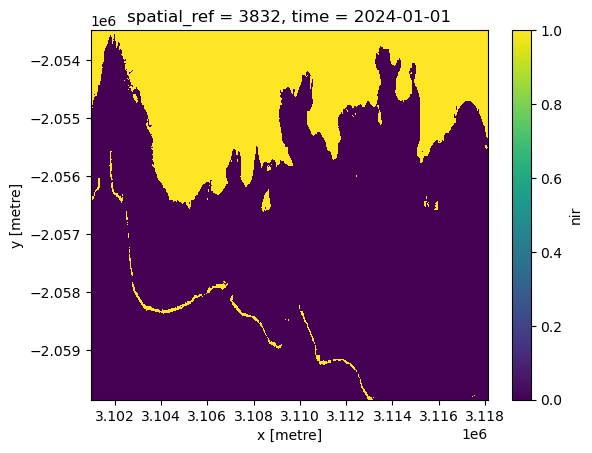

In [40]:
surf_mask = surf_mask.astype(bool)
surf_mask.plot()


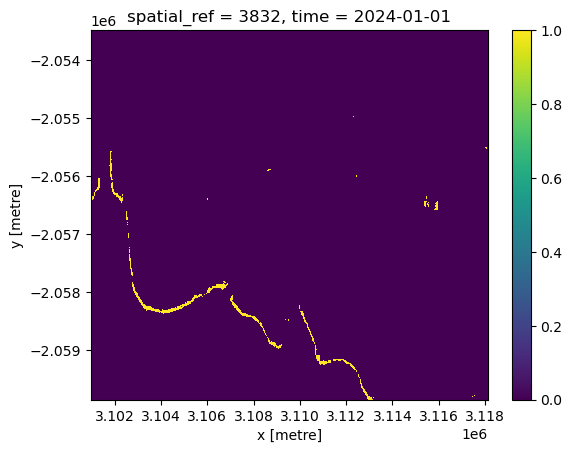

In [41]:
surf_mask = surf_mask & water_mask
surf_mask.plot()

In [42]:
# surf_mask = surf_mask.astype('uint8')
# surf_mask.odc.write_cog("surf_mask.tif", overwrite=True)

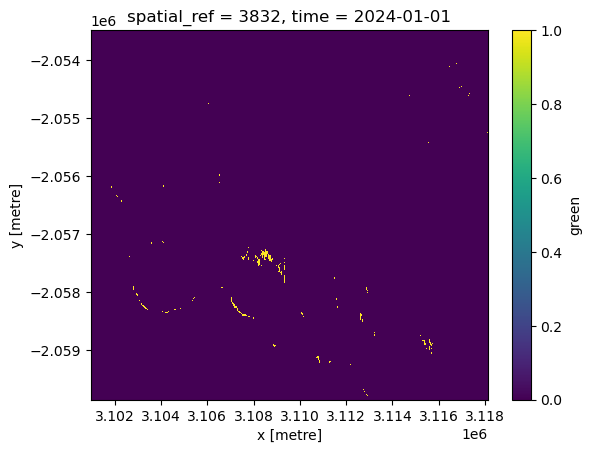

In [62]:
# from scipy.ndimage import binary_dilation
surf_rgb_threshold = 0.16

surf_green = combined.green > surf_green_threshold
surf_green.plot()

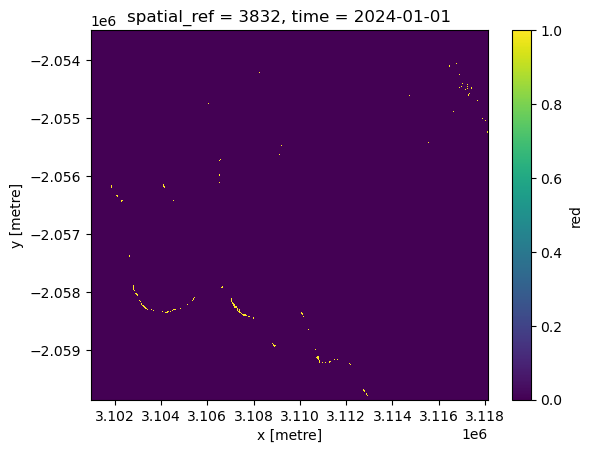

In [63]:
surf_red = combined.red > surf_rgb_threshold
surf_red.plot()

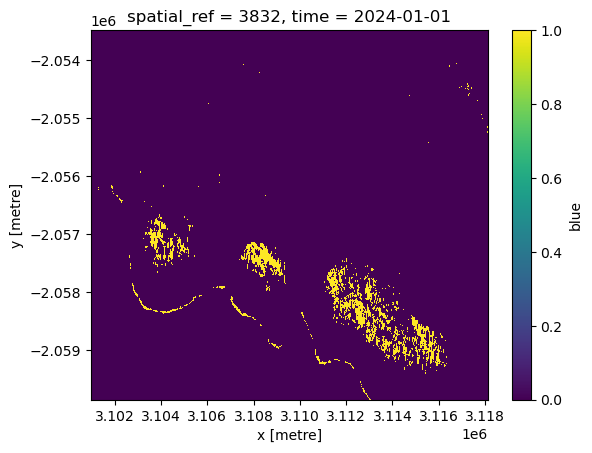

In [64]:
surf_blue = combined.blue > surf_rgb_threshold
surf_blue.plot()

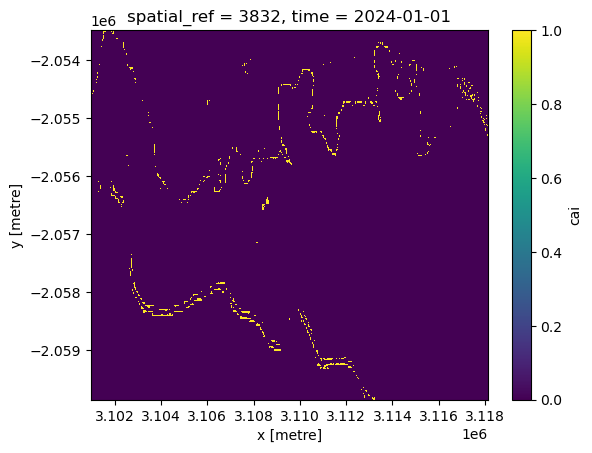

In [66]:
surf_cai = combined.cai > surf_rgb_threshold
surf_cai.plot()

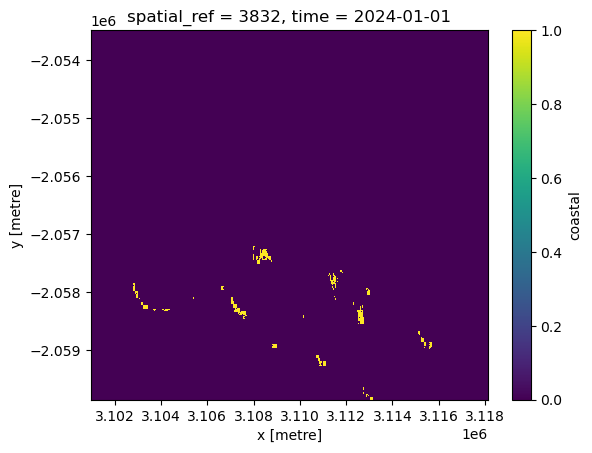

In [68]:
coastal_thresold = 0.14
surf_coastal = combined.coastal > coastal_thresold
surf_coastal.plot()

In [43]:
surf_mask

<xarray.DataArray (y: 638, x: 1714)> Size: 1MB
dask.array<bitwise_and, shape=(638, 1714), dtype=bool, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5kB -2.053e+06 -2.053e+06 ... -2.06e+06 -2.06e+06
  * x            (x) float64 14kB 3.101e+06 3.101e+06 ... 3.118e+06 3.118e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01

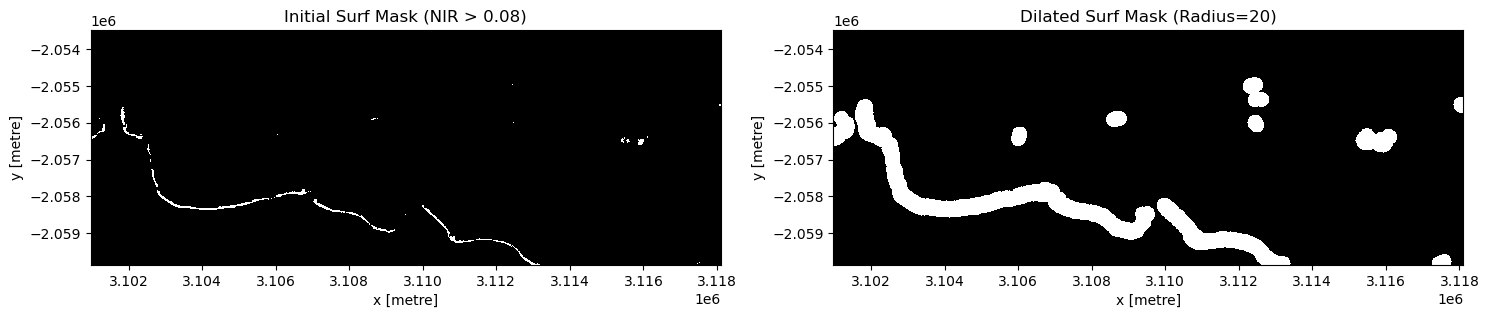

In [44]:

surf_mask = surf_mask.chunk({'x': 512, 'y': 512})

surf_mask = surf_mask.astype(bool)
surf_dilation_radius = 20


dilated_surf_mask = binary_dilation(surf_mask, radius=surf_dilation_radius)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot Initial Mask
surf_mask.plot.imshow(
    ax=axes[0],
    cmap='gray', # 'gray' or 'Greys_r' are good for binary masks
    add_colorbar=False
)
axes[0].set_title(f'Initial Surf Mask (NIR > {surf_threshold})')
axes[0].set_aspect('equal', adjustable='box')


# Plot Dilated Mask
dilated_surf_mask.plot.imshow(
    ax=axes[1],
    cmap='gray', # Use the same colormap for comparison
    add_colorbar=False
)
axes[1].set_title(f'Dilated Surf Mask (Radius={surf_dilation_radius})')
axes[1].set_aspect('equal', adjustable='box')


plt.tight_layout()
plt.show()


In [45]:
masked_combined = masked_combined.where(~dilated_surf_mask)

In [53]:
surf_mask = surf_mask.astype('uint8')
surf_mask.odc.write_cog("surf_mask.tif", overwrite=True)

PosixPath('surf_mask.tif')

In [52]:
dilated_surf_mask = dilated_surf_mask.astype('uint8')
dilated_surf_mask.odc.write_cog("masked_combined.tif", overwrite=True)

PosixPath('masked_combined.tif')

In [46]:
masked_combined.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 27.13 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/odc/geo/_rgba.py:55: RuntimeWarning: invalid value encountered in cast
  return x.astype("uint8")
/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [50]:
# masked_combined = masked_combined.astype('uint8')
# masked_combined.red.odc.write_cog("masked_combined.tif", overwrite=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 10.44 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


PosixPath('masked_combined.tif')

In [47]:
# masked_combined = masked_combined.where(

### Postcard csv

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [ ]:
# Reproject training data to the GeoMAD CRS and convert to xarray
training_reprojected = training.to_crs(masked_combined.odc.crs)
training_da = training_reprojected.assign(
    x=training_reprojected.geometry.x, y=training_reprojected.geometry.y
).to_xarray()

# Extract training values from the masked dataset
training_values = (
    masked_combined.sel(training_da[["x", "y"]], method="nearest")
    .squeeze()
    .compute()
    .to_pandas()
)
training_values

In [ ]:
# Join the training data with the extracted values and remove unnecessary columns
training_array = pd.concat([training["cc_id"], training_values], axis=1)

# Drop rows where there was no data available
training_array = training_array.dropna()

# Preview our resulting training array
training_array.head()

In [ ]:
print(training_array.shape[1], 'total columns')
print('columns included', training_array.columns)

In [ ]:
standard_schema = ['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1',
       'rededge2', 'rededge3', 'mndwi', 'ndti', 'cai', 'ndvi', 'evi', 'savi',
       'ndwi', 'b_g', 'b_r', 'mci', 'ndci', 'ln_bg', 'contrast', 'homogeneity',
       'energy', 'ASM', 'correlation', 'mean', 'entropy', 'y', 'x', 'time',
       'spatial_ref']

In [ ]:
training_array=training_array[standard_schema]

In [ ]:
training_array=training_array.drop(columns=["spatial_ref", "time"])

In [ ]:
# Write the training data to a CSV file
training_array.to_csv(f"training-data/csvs/{version}-training.csv", index=False)

In [ ]:
training_array["cc_id"].dtype